# Solving Laplace's equation: The relaxation method

The relaxation method is a numerical technique used to solve Laplace's equation, which is a partial differential equation (PDE) often encountered in physics and engineering, especially in problems involving electrostatics, fluid flow, and heat conduction. The method is particularly useful for problems with complex geometries where analytical solutions are difficult or impossible to obtain. Laplace's equation in two dimensions is given by:

$$ \nabla^2 V = \frac{\partial^2 V}{\partial x^2} + \frac{\partial^2 V}{\partial y^2} + \frac{\partial^2 V}{\partial z^2}= 0, $$

where $V$ is the electic potential.  Before we jump into solving this equation, we need to do a little background work. 

## Computing numerical derivatives: functions of one variable

Suppose we want to numerically compute the derivative of a function $f(x)$. We know from calculus that we could approximate the derivative using 

$$ \frac{df}{dx} \approx \frac{f(x+\Delta x) - f(x)}{\Delta x};$$

where $\Delta x$ is some small displacement. In numerical methods, this is called the <font color='green'>*forward derivative*</font>. We could also approximate the derivative using the 
<font color='green'>*reverse derivative*</font>:

$$ \frac{df}{dx} \approx \frac{f(x) - f(x-\Delta x)}{\Delta x};$$

or even the <font color='green'>*central difference*</font>:

$$ \frac{df}{dx} \approx \frac{f(x+\frac{\Delta x}{2}) - f(x-\frac{\Delta x}{2})}{\Delta x},$$

which, I suppose you could equally well write as 

$$ \frac{df}{dx} \approx \frac{f(x+\Delta x) - f(x-\Delta x)}{2\Delta x}.$$

### <font color='orange'>Practice #1: Write you're own functions to compute the forward, reverse, and central derivatives:</font>
In the code cell below, compose three functions to compute these three derivatives. Call them `forward_diff`, `reverse_diff`, and `central_diff` respectively.

### <font color='orange'>Practice #2: Test your functions</font>
Now, with $f(x) = \sin(2\pi x)$, plot $f(x)$ and its derivative (using each of the three methods). 

## Computing the Laplacian: $\nabla^2 V(x,y,z)$

In order to compute the Laplacian, we need to compute *partial derivatives* of the potential, $V(x,y,z)$. We can numerically compute the partial derivatives in a manner similar to what we did above, except this time, we will be taking the derivatives with respect to $x$ (while holding $y$ and $z$ constant) and with respect to $y$ (while holding $x$ and $z$ constant). For example, we can compute the partial derivative of $V$ with respect to $x$ using the forward derivative as follows: (here, we are imagining that we have $V(x,y,z)$ computed on a grid of points ($i,j,k$):

$$ \frac{\partial V}{\partial x} \approx \frac{V(i+1,j,k) - V(i,j,k)}{\Delta x}$$

or, we could use the reverse derivative to write:

$$ \frac{\partial V}{\partial x} \approx \frac{V(i,j,k) - V(i-1,j,k)}{\Delta x}$$

The above two equations effectively tell us the derivative at the points $i+\frac{1}{2}$ and $i -\frac{1}{2}$, respectively; i.e. I conceptually think of these equations as:

$$ \frac{\partial V}{\partial x}(i+\frac{1}{2},j,k) \approx \frac{V(i+1,j,k) - V(i,j,k)}{\Delta x}$$

or, we could use the reverse derivative to write:

$$ \frac{\partial V}{\partial x}(i -\frac{1}{2},j,k) \approx \frac{V(i,j,k) - V(i-1,j,k)}{\Delta x}$$

Thus to take one more derivative, (remember, we want $\frac{\partial^2 V}{\partial x^2}$) we can use the central difference method to write

$$ \frac{\partial^2 V}{\partial x^2} \approx \frac{1}{\Delta x} \left[ \frac{\partial V}{\partial x}(i+\frac{1}{2},j,k) - 
\frac{\partial V}{\partial x}(i -\frac{1}{2},j,k) \right]$$

or, 

$$ \frac{\partial^2 V}{\partial x^2} \approx \frac{1}{\Delta x} \left[ \frac{V(i+1,j,k) - V(i,j,k)}{\Delta x} - 
\frac{V(i,j,k) - V(i-1,j,k)}{\Delta x} \right]$$

and similarly, we obtain equations for the $y$ and $z$ second partial derivatives as 

$$ \frac{\partial^2 V}{\partial y^2} \approx \frac{1}{\Delta y} \left[ \frac{V(i,j+1,k) - V(i,j,k)}{\Delta y} - 
\frac{V(i,j,k) - V(i,j-1,k)}{\Delta y} \right]$$

and 

$$ \frac{\partial^2 V}{\partial z^2} \approx \frac{1}{\Delta z} \left[ \frac{V(i,j,k+1) - V(i,j,k)}{\Delta z} - 
\frac{V(i,j,k) - V(i,j,k-1)}{\Delta z} \right]$$

Now we substitute these second partial derivatives into Laplace's equation (with the assumption that we choose $\Delta x = \Delta y = \Delta z$, and we obtain:

$$V(i,j,k) = \frac{1}{6}\left(V(i+1,j,k) + V(i-1,j,k) + V(i,j+1,k) + V(i,j-1,k) + V(i,j,k+1)  + V(i,j,k-1)\right) $$

and <font color='green'>in two dimensions</font>, we obtain 
<font color='orange'>
$$V(i,j,k) = \frac{1}{4}\left(V(i+1,j,k) + V(i-1,j,k) + V(i,j+1,k) + V(i,j-1,k) \right) $$
</font>
Looking at these expressions, you can see that the potential at a point is the average of the values at its neighbors. 

In [38]:
using Plots
using LaTeXStrings, Measures
default(fontfamily = "Computer Modern", size=(800,500), titlefont = (16), legendfontsize = 10, 
        guidefont = (16, :darkgreen), tickfont = (12, :black), 
        framestyle = :box, yminorgrid = true)


Converged after 7154 iterations.


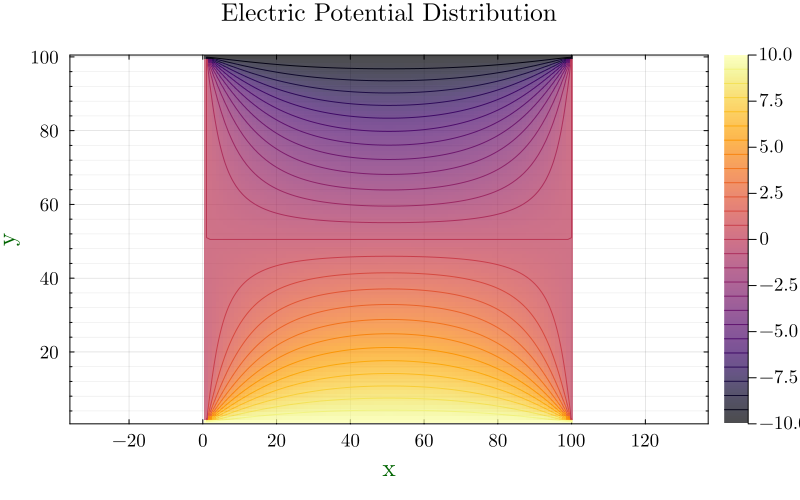

In [39]:
function solve_capacitor_potential(V0, N, epsilon, max_iter, tol)
    # Initialize potential matrix
    V = zeros(N, N)
    
    # Set boundary conditions
    V[1, : ] .= V0
    
    V[end, : ] .= -V0
    
    # Relaxation loop
    for iter in 1:max_iter
        # Copy current potential values to avoid updating in-place
        V_new = copy(V)
        
        # Update potential for inner points
        for i in 2:N-1
            for j in 2:N-1
                V_new[i, j] = 0.25 * (V[i+1, j] + V[i-1, j] + V[i, j+1] + V[i, j-1])
            end
        end
        
        # Calculate maximum change in potential
        max_diff = maximum(abs.(V_new - V))
        
        # Update potential
        V .= V_new
        
        # Check convergence
        if max_diff < tol
            println("Converged after $iter iterations.")
            break
        end
    end
    
    return V
end

# Parameters
V0 = 10.0   # Voltage of the capacitor plates
N = 100     # Number of grid points in each dimension
epsilon = 1.0  # Permittivity of the medium
max_iter = 10000  # Maximum number of iterations
tol = 1e-6  # Tolerance for convergence

# Solve for potential
V = solve_capacitor_potential(V0, N, epsilon, max_iter, tol)

# Plot potential

contour(1:N,1:N,V, levels=25)
heatmap!(V, aspect_ratio=:equal, xlabel="x", ylabel="y", title="Electric Potential Distribution", alpha=0.7)



## The Relaxation method

The relaxation method solves Laplace's equation by iteratively updating the values of $V$ on a discrete grid until the solution converges to a steady state that satisfies the equation within a specified tolerance. 
The basic steps are as follows:

>    (1) Discretization: The domain of interest is divided into a grid of points. The continuous spatial variables (x) and (y) are replaced by discrete indices (i) and (j), respectively. The differential equation is then approximated using finite differences.</br>
>    (2) Initial Guess: An initial guess is made for the values of $V$ at each grid point. Boundary conditions are applied according to the problem's specifications.</br>
>    (3) Iterative Update (Relaxation): The value of $V$ at each interior grid point is updated iteratively based on the values of its neighbors. A common approach is to use the average of the neighboring values, which corresponds to the Jacobi method:

$$ V_{i,j}^{(new)} = \frac{1}{4} \left( V_{i+1,j} + V_{i-1,j} + V_{i,j+1} + V_{i,j-1} \right) $$

Alternatively, more sophisticated methods like Gauss-Seidel or Successive Overrelaxation (SOR) can be used to potentially improve convergence rates. 
These methods use newly updated values as soon as they are computed.
>    (4) Convergence Check: After each iteration, the difference between the old and new values of $V$ is checked. If the maximum difference across all grid points is below a pre-defined threshold, the solution is considered converged, and the process stops.</br>
>    (5) Boundary Conditions: Boundary conditions are applied at each iteration to ensure that the solution conforms to the physical constraints of the problem.The relaxation method is straightforward to implement and can handle complex boundary conditions and geometries. However, it can be computationally intensive for large grids or for problems requiring high precision, as the convergence can be slow. Techniques like multigrid methods can be employed to accelerate convergence.

# Assignment 11:
## Due 23 April 9 am
Using the relaxation method, compute the electric potential around and between the plates of a capacitor. </br>
Requirements:</br>
    1. use a 100 x 100 grid. </br>
    2. the plates are located from </br>
        a)top plate: rows 58 through 62, columns 20 through 80; V = +V0</br>
        b) bottom plate: rows 38 through 42, columns 20 through 80; V = -V0</br>
    3. Explain your thinking (as usual!), and make sure to include a contour and heatmap plot. 
    4. You'll have to think about how to modify the relaxation method to account for the plates location and extent.</br>
    5. You may very well have to embed this system in a larger array 2D box where the potential is zero at all edges. I'm not sure about this at the moment :-)</br>
    6. Extra credit: compute the electric field lines and show them as streamlines along with the equipotentials